In [131]:
from pyaudi import gdual_double, gdual_vdouble
import pyaudi as pa 
import Utils.DA as da
import numpy as np
import matplotlib.pyplot as plt 
from Utils.boxgrid import boxgrid

# Tool dev

In [ ]:
class Interval:
    def __init__(self, lower, upper):
        assert upper > lower
        self.interval = (lower, upper)
        self.midpoint = 0.5*(lower+upper)
        self.size = upper-lower
        
    def split(self):
        I1 = Interval(self.interval[0], self.midpoint)
        I2 = Interval(self.midpoint, self.interval[1])
        return I1,I2
    
    def __str__(self):
        return "I[{}, {}]".format(*self.interval)
    
    def __contains__(self, x):
        x = np.asarray(x)
        return np.logical_and(x<=self.interval[1], x>=self.interval[0])
    
# class History:
#     """ A collection of intervals """
#     def __init__(self)
#         self._history = []
#     def find(self, val):
        # """ Determines the interval in which value lies"""
    
def Construct(interval, nsubintervals):
    """ Decomposes an interval into n sub-intervals of equal length"""
    a,b = interval.interval
    ends = np.linspace(a,b,nsubintervals+1)
    return [Interval(a,b) for a,b in zip(ends, ends[1:])]

def find_nearest(array, values):
    """ Finds the deltas at which to evaluate the DAs, and
    returns a collection of indices referring to which results to keep
    Inputs: 
    array - array of (scalar, for now) evaluation points
    values - array of expansion points (midpoints of intervals)
    """
    array = np.asarray(array)
    values = np.asarray(values)
    big_array = np.array([array-value for value in values]) # array of all possible deltas 
#     print(big_array)
#     print(np.linalg.norm(big_array, axis=2))
    if array.squeeze().ndim == 1:
        idx = np.abs(big_array).argmin(axis=0)
    else:
        idx = np.linalg.norm(big_array, axis=2).argmin(axis=0)
    midx = [(a,b) for a,b in zip(idx, range(len(idx)))]
    return [big_array[tup] for tup in midx], midx

# print(find_nearest(np.linspace(0,2,11),[0.33,0.66, 1, 1.33, 1.66]))


In [118]:
# 1-D Test
d,midx = find_nearest(np.linspace(0,2,3),[0.5,1.5])
print(d)

# Same thing with a useless second element 
evals = np.zeros((2,3))
evals[0,:] = np.linspace(0,2,3)
print(evals)

[-0.5, 0.5, 0.5]
[[0. 1. 2.]
 [0. 0. 0.]]


In [117]:
exp = [[0.5,0.2],[0.2,0.]]
ev = [[0.25,-0.1],[0.5,0.1]]
print(find_nearest(ev,exp))

([array([ 0.05, -0.1 ]), array([ 0. , -0.1])], [(1, 0), (0, 1)])


In [116]:
# Another 2-D Test
exp = [[0.25,0.25],[0.75,0.75]]
ev = [[0.25,0.3],[0.9,0],[0.6,0.4]]
print(find_nearest(ev,exp))

([array([0.  , 0.05]), array([ 0.65, -0.25]), array([0.35, 0.15])], [(0, 0), (0, 1), (0, 2)])


# Scalar test case 

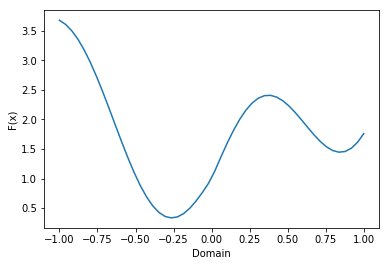

In [113]:
domain = (-1,1)
def fun(x):
    if isinstance(x, (gdual_double, gdual_vdouble)):
        return pa.sin(5*x) + pa.exp(pa.abs(x))
    else:
        return np.sin(5*x) + np.exp(np.abs(x))
x = np.linspace(*domain)
y = fun(x)
plt.figure(1)
plt.plot(x,y)
plt.xlabel('Domain')
plt.ylabel('F(x)')

Try single polynomials of different orders.

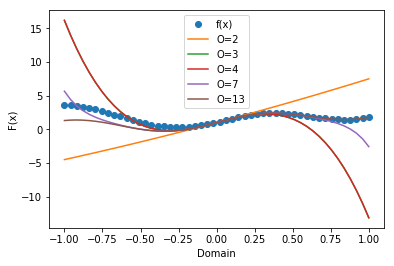

In [120]:
plt.figure(1)
plt.plot(x,y,'o',label='f(x)')
plt.xlabel('Domain')
plt.ylabel('F(x)')
for order in [2,3,4,7,13]:
    xda = gdual_double(I.midpoint, 'x', order)
    yda = fun(xda)
#     print(yda)
    ye = da.evaluate([yda], 'x', x)
    plt.plot(x,ye,label='O={}'.format(order))
plt.legend()

## Scalar test case

In [129]:
I0 = Construct(I,8)
expansion_points = [Ii.midpoint for Ii in I0]
deltas, keep = find_nearest(x, expansion_points)
xda = gdual_vdouble(expansion_points, 'x', 3)
yda = fun(xda)
ye = da.evaluate([yda], 'x', deltas).squeeze() # This is all expansion points evaluated at x points
sol = [ye.T[pair] for pair in keep]
y_expansion = yda.constant_cf


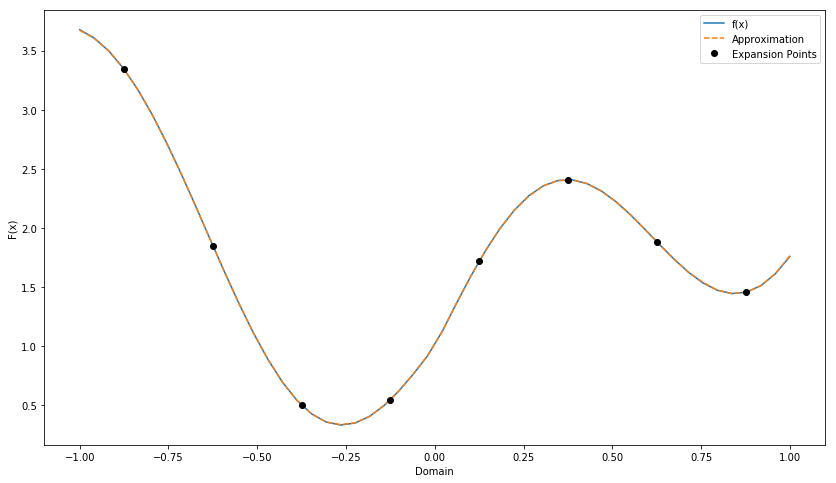

In [130]:
plt.figure(1, figsize=(14,8))
plt.plot(x,y,'-',label='f(x)')
plt.plot(x,sol,'--',label='Approximation')
plt.plot(expansion_points,y_expansion,'ko',label='Expansion Points')

plt.xlabel('Domain')
plt.ylabel('F(x)')

plt.legend()

A relatively low number of low order polynomials represents the nonlinear, non-differentiable function well.

# 2-D Case 

(2, 2500)


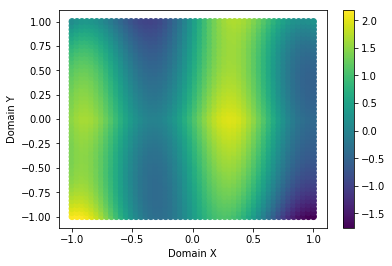

In [141]:
domain = [(-1,1)]*2
def fun(x):
    if isinstance(x, (gdual_double, gdual_vdouble)):
        return pa.sin(5*x[0]) + pa.cos(x[0]**2)*pa.exp(-pa.abs(x[1])) + x[0]*x[1]**3
    else:
        return np.sin(5*x[0]) + np.cos(x[0]**2)*np.exp(-np.abs(x[1])) + x[0]*x[1]**3
x = boxgrid(domain, 50, True).T
print(x.shape)
y = fun(x)
plt.figure(1)
plt.scatter(x[0],x[1],c=y)
plt.colorbar()
plt.xlabel('Domain X')
plt.ylabel('Domain Y')

In [ ]:
x_exp = boxgrid(domain, 3, True)
x_eval = boxgrid(domain,7, True)